# GlobalAveragePooling (GAP)
- Feature map의 채널별로 평균값을 추출 1 x 1 x channel 의 Feature map을 생성
- `model.add(keras.layers.GlobalAveragePooling2D())`
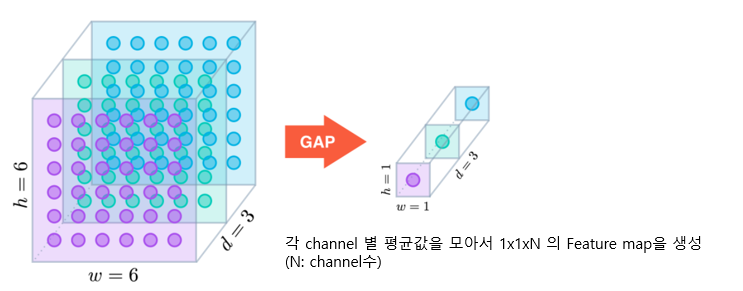

- Feature Extraction layer에서 추출한 Feature map을 Classifier layer로 Flatten해서 전달하면 많은 연결노드와 파라미터가 필요하게된다. GAP를 사용하면 노드와 파라미터의 개수를 효과적으로 줄일 수 있다.
- Feature map의 채널수가 많을 경우 GAP를 사용하는 것이 효과적이나 채널수가 적다면 Flatten을 사용하는 것이 좋다.
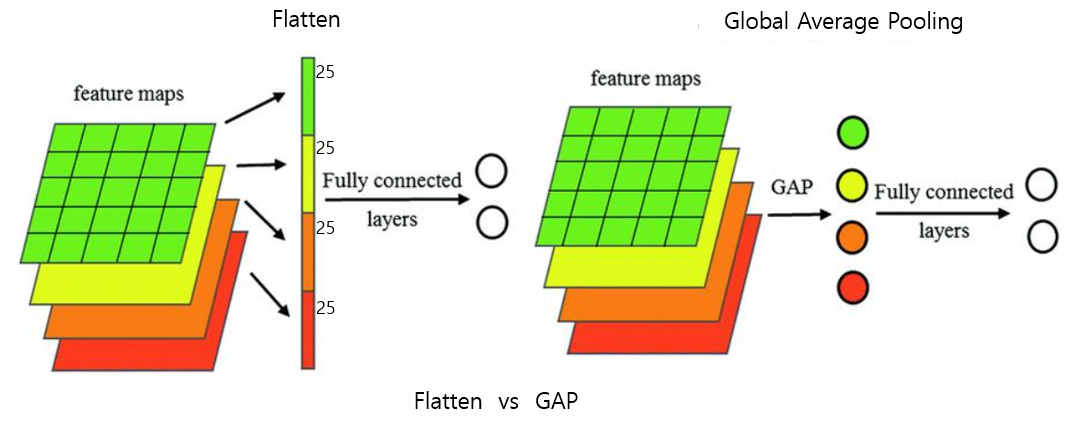

In [ ]:
# 이미지 다운로드
import gdown
url = 'https://drive.google.com/uc?id=1nBE3N2cXQGwD8JaD0JZ2LmFD-n3D5hVU'
fname = 'cats_and_dogs_small.zip'
gdown.download(url, fname, quiet=False)

In [ ]:
!mkdir data

In [ ]:
## 압축 풀기
!unzip -q ./cats_and_dogs_small.zip -d data/cats_and_dogs_small

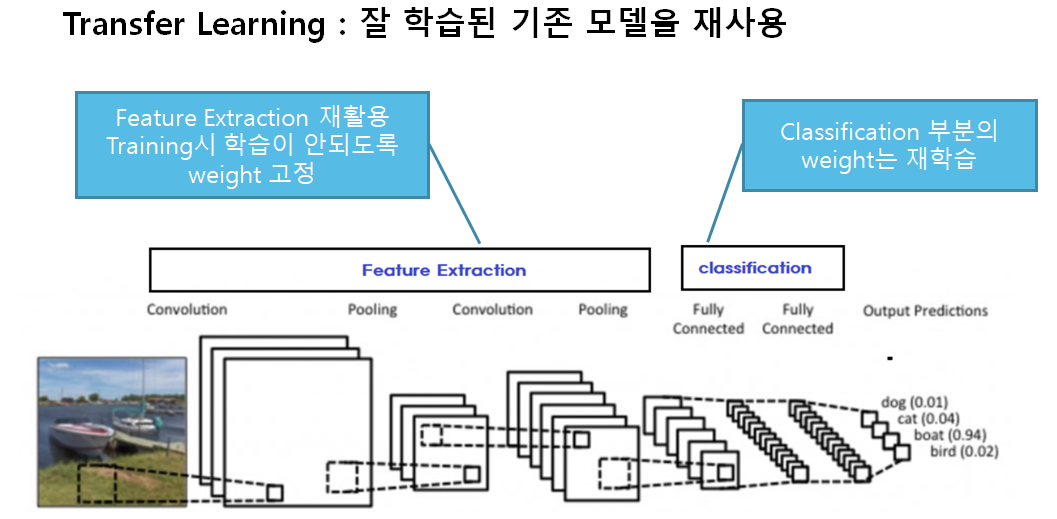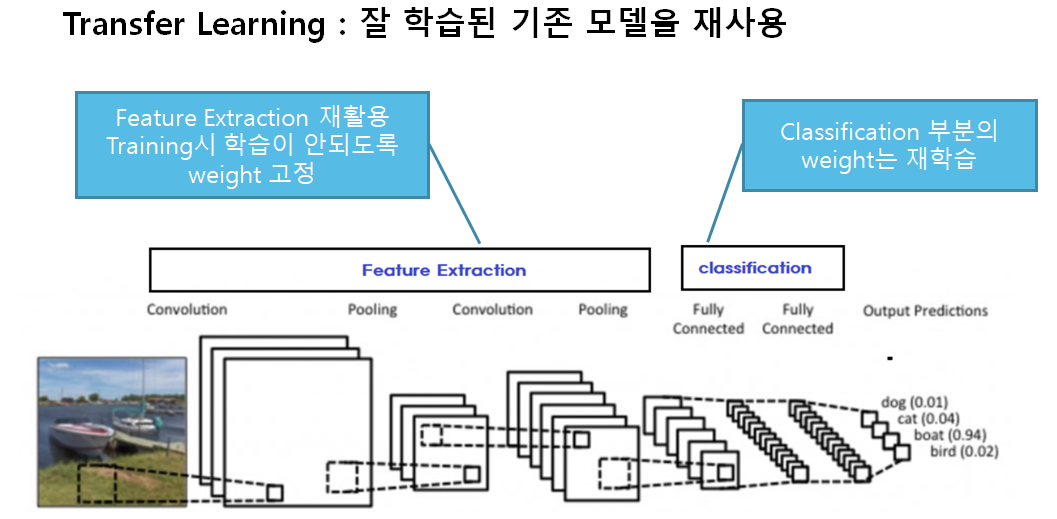

## Transfer learning (전이학습)
- 큰 데이터 셋을 이용해 미리 학습된 pre-trained Model의 Weight를 사용하여 현재 하려는 예측 문제에 활용. 
- ### Convolution base(Feature Extraction 부분)만 활용
    - Convolution base는 이미지에 나타나는 일반적인 특성을 파악하기 위한 부분이므로 재사용할 수 있다.
    - Classifier 부분은 학습하려는 데이터셋의 class들에 맞게 변경 해야 하므로 재사용할 수 없다.
- Pretrained Convlution layer의 활용 
    - Feature extraction
        - 학습시 학습되지 않고 Feature를 추출하는 역할만 한다.
    - Fine tuning
        - 학습시 Pretrained Covolution layer도 같이 학습해서 내 데이터셋에 맞춘다.

## Feature extraction
- 기존의 학습된 network에서 fully connected layer를 제외한 나머지 weight를 고정하고 새로운 목적에 맞는 fully connected layer를 추가하여 추가된 weight만 학습하는 방법
- `tensorflow.keras.applications` module이 지원하는  image classification models
    - (https://www.tensorflow.org/api_docs/python/tf/keras/applications)    

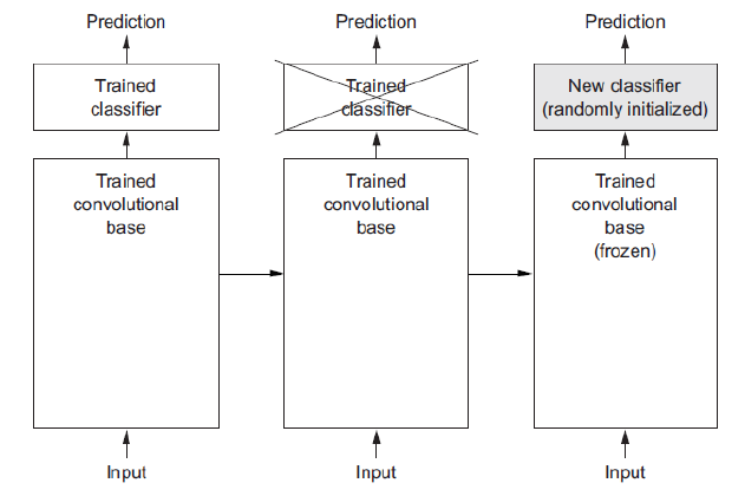

# Pre-Trained Model(미리 학습된 모델)을 이용한 전이학습

## Keras에서 제공하는 Pre-Trained Model 
- tensorflow.keras.applications 패키지를 통해 제공
    - https://www.tensorflow.org/api_docs/python/tf/keras/applications?hl=ko
    - Modules
        - 각 모델 생성 함수와 전처리 함수제공
    - Functions
        - 모델 생성함수 제공
- 모델 생성함수의 주요 매개변수
    - `weights`: 모형의 학습된 weight. 기본값- 'imagenet'
    - `include_top`: fully connected layer를 포함할지 여부. True 포함시킴, False: 포함 안 시킴
    - `input_shape`: 사용자가 입력할 이미지의 크기 shape. 3D 텐서로 지정. (높이, 너비, 채널). 기본값: (224,224, 3)

## Feature extraction의 두 가지 방법
1. **빠른 추출방식**
    - 예측하려는 새로운 데이터를 위의 `conv_base`에 입력하여 나온 출력값을 numpy 배열로 저장하고 이를 분류 모델의 입력값으로 사용. Convolution operation을 하지 않아도 되기 때문에 빠르게 학습. 하지만 data augmentation 방법을 사용할 수 없음.

2. **받아온 특성 Layer를 이용해 새로운 모델 구현하는 방식**
    - 위의 `conv_base` 이후에 새로운 layer를 쌓아 확장한 뒤 전체 모델을 다시 학습. 모든 데이터가 convolution layer들을 통과해야 하기 때문에 학습이 느림. 단 conv_base의 가중치는 업데이트 되지 않도록 한다. data augmentation 방법을 사용할 수 있음.

### 빠른 특성 추출 방식


- `conv_base`의 predict 메소드로 입력 이미지의 feature를 추출 

## Pretrained Network를 이용해 새로운 모델 구현하는 방식

- Conv_base의 feature extraction 부분에 fully connected layer를 추가하여 모형 생성 
- Conv_base에서 가져온 부분은 학습을 하지 않고 weight를 고정
    -  **Layer.trainable=False**

## 미세조정(Fine-tuning)
- Pretrained 모델을 내가 학습시켜야 하는 데이터셋(Custom Dataset)에 재학습시키는 것을 fine tunning 이라고 한다.
- 주어진 문제에 더 적합하도록 모델의 가중치들을 조정.

### Fine tuning 전략
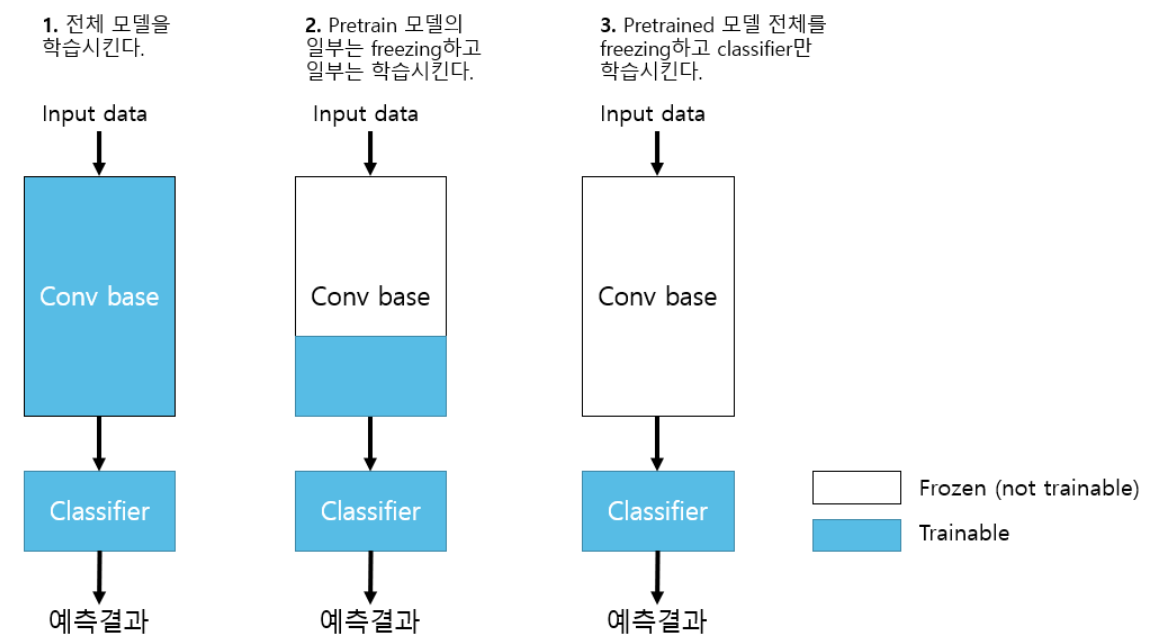

- **세 전략 모두 classifier layer들은 train한다.**

1. <span style="font-size:1.2em;font-weight:bold">전체 모델을 전부 학습시킨다.(1번)</span>
    - Pretrained 모델의 weight는 Feature extraction 의 초기 weight 역할을 한다.
    - **Train dataset의 양이 많고** Pretrained 모델이 학습했던 dataset과 Custom dataset의 class간의 유사성이 **낮은 경우** 적용.
    - 학습에 시간이 많이 걸린다.
2. <span style="font-size:1.2em;font-weight:bold">Pretrained 모델 Bottom layer들(Input과 가까운 Layer들)은 고정시키고 Top layer의 일부를 재학습시킨다.(2번)</span>
    - **Train dataset의 양이 많고** Pretrained 모델이 학습했던 dataset과 Custom dataset의 class간의 유사성이 **높은 경우** 적용.
    - **Train dataset의 양이 적고** Pretained 모델이 학습했던 dataset과 custom dataset의 class간의 유사성이 **낮은 경우** 적용
3. <span style="font-size:1.2em;font-weight:bold">Pretrained 모델 전체를 고정시키고 classifier layer들만 학습시킨다.(3번)</span>
    - **Train dataset의 양이 적고** Pretrained 모델이 학습했던 dataset과 Custom dataset의 class간의 유사성이 **높은 경우** 적용.
  
  
> custom dataset: 내가 학습시키고자 하는 dataset 

## Model, Layer에서 weight 조회

### Model에서 Layer들 조회
- model객체.layers
    - 모델을 구성하는 layer 객체들을 담은 리스트
- model객체.get_layer(Layer이름:str)
    - argument로 전달한 이름의 Layer객체를 반환
    
### Model과 Layer의 weight들 조회 및 설정
- Layer와 Model은 Weight조회와 관련해 세가지 속성을 제공
    - weights: 레이어의 모든 weight 변수들을 담은 리스트
        - get_weights() : 레이어의 모든 weight 변수 리스트를 카피해서 반환한다.
    - trainable_weights: Train(학습)시 업데이트 되는 weights들 리스트
    - non_trainable_weights: Train(학습)시 업데이트 되지 않는(훈련되지 않는) weights들 리스트
- Layer와 Model은 boolean 값을 가지는 속성 `trainable`을 제공
    - trainable을 False로 설정하면 Layer의 weights들이 훈련가능에서 **훈련 불가능** 상태로 변경된다. 이런 상태를 **Frozen-동결** 이라고 하며 학습시 weight들이 업데이트 되지 않는다.

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras import applications

import numpy as np

In [26]:
# 추론할 이미지를 로드(load)
img = load_img('data/shark.jpg', target_size=(224,224))  # pillow jpg image 타입
img_np = img_to_array(img)  # ndarray 변환
print(img_np.shape)
img_np = img_np[np.newaxis, ...]  # batch 축 추가.
print(img_np.shape)

(224, 224, 3)
(1, 224, 224, 3)


In [27]:
# Image 전처리
img_tensor = applications.vgg16.preprocess_input(img_np)  # 케라스 VGG16 모델에서 했던 전처리 방식을 적용 

In [28]:
# 모델 생성 및 추론
vgg16 = applications.VGG16()  # include_top=True(기본) - classification layer를 포함.
vgg16.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [29]:
pred = vgg16.predict(img_tensor)

In [30]:
len(pred[0])

1000

In [31]:
pred_label = np.argmax(pred, axis=1)
pred_label, pred[0, 3]

(array([3], dtype=int64), 0.955679)

In [32]:
pred_cls = applications.vgg16.decode_predictions(pred, top=3)  # 가장 높은 확률로 예측한 top n(5)개의 label을 출력

In [33]:
pred_cls

[[('n01491361', 'tiger_shark', 0.955679),
  ('n01484850', 'great_white_shark', 0.042227015),
  ('n02640242', 'sturgeon', 0.0009074703)]]

mobilenet 이용해 추론

In [25]:
# 추론할 이미지를 로드(load)
img = load_img('data/shark.jpg', target_size=(224,224))
img_np = img_to_array(img)  # ndarray 변환
print(img_np.shape)
img_np = img_np[np.newaxis, ...]  # batch 축 추가.
print(img_np.shape)

(224, 224, 3)
(1, 224, 224, 3)


In [34]:
# 전처리
img_tensor = applications.mobilenet.preprocess_input(img_np)

In [36]:
m_net = applications.MobileNet()

17227776/17225924 [==============================] - 3s 0us/step


In [37]:
m_net = applications.MobileNet()

In [38]:
m_net = applications.MobileNet()

In [39]:
pred = m_net.predict(img_tensor)
pred_label = np.argmax(pred, axis=-1)
pred_label

array([3], dtype=int64)

In [41]:
pred_cls = applications.mobilenet.decode_predictions(pred)
pred_cls

[[('n01491361', 'tiger_shark', 0.9994462),
  ('n01494475', 'hammerhead', 0.00026250258),
  ('n01484850', 'great_white_shark', 0.00022831344),
  ('n02641379', 'gar', 3.197814e-05),
  ('n02640242', 'sturgeon', 1.6791651e-05)]]

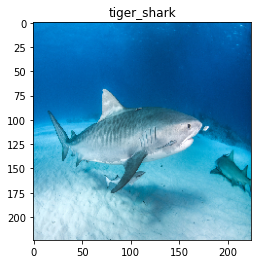

In [42]:
import matplotlib.pyplot as plt
plt.imshow(img)
plt.title(pred_cls[0][0][1])
plt.show()

### Pretrained 모델 Bottom layer들(Input과 가까운 Layer들)은 고정시키고 Top layer의 일부를 재학습

- Conv_base에서 가장 Top부분에 있는 레이어에 대해 fine-tuning.
    - 앞의 layer들은 비교적 일반적이고 재사용 가능한 feature를 학습
    - 너무 많은 parameter를 학습시키면 overfitting의 위험이 있음 (특히 새로운 데이터의 수가 적을 때)

In [45]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import applications
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array

import numpy as np

np.random.seed(0)
tf.random.set_seed(0)

In [46]:
# 하이퍼 파라미터
LEARNING_RATE = 0.001
N_EPOCHS = 30
N_BATCHS = 100

IMAGE_SIZE = (224, 224)

In [48]:
def extract_featuremap(img_path, sample_counts):
    """
    매개변수로 받은 경로의 이미지들을 Feature Extractor 모델(Conv base)을 통과 시켜 Feature Map들을 추출해 반환하는 함수
    [매개변수]
        img_path : str - 이미지 데이터셋이 있는 root 경로
        sample_count : int - 특성을 추출할 이미지 개수
    [반환값]
        Tuple : (feature map들 : ndarray, label : ndarray)
    """
    conv_base = applications.VGG16(include_top=False, input_shape=IMAGE_SIZE+(3,))
    # 결과를 담을 ndarray 생성
    # feature map을 담을 ndarray
    result_featuremaps = np.zeros(shape=(sample_counts, 7, 7, 512))
    # label 을 담을 ndarray
    result_labels = np.zeros(shape=(sample_counts, ))
    
    # ImageDataGenerator 생성
    img_gen = ImageDataGenerator(preprocessing_function=applications.vgg16.preprocess_input)  # 전처리 함수를 설정
    img_iter = img_gen.flow_from_directory(img_path, target_size=IMAGE_SIZE, batch_size=N_BATCHS, class_mode='binary')
    
    cnt = 0 # 반복횟수
    for input_batch, label_batch in img_iter:
        feature_map = conv_base.predict(input_batch)  # batch 단위로 읽어온 이미지를 conv_base를 이용해 predict => output feature map이 반환된다.
        # 결과를 담을 ndarray에 추가
        result_featuremaps[cnt*N_BATCHS: (cnt+1)*N_BATCHS] = feature_map
        result_labels [cnt*N_BATCHS: (cnt+1)*N_BATCHS] = label_batch
        
        cnt += 1
        if cnt*N_BATCHS >= sample_counts:  # 다음 결과를 저장할 배열의 시작 index가 samplt_counts 이상이면 반복문을 빠져 나온다. (원하는 개수의 feature map을 다 저장했으므로.)
            break
            
        return result_featuremaps, result_labels
        

In [50]:
train_path = 'data/train/cats_and_dogs_small/'
validation_path = 'data/validation/cats_and_dogs_small/'
test_path =  'data/test/cats_and_small/'

train_features, train_labels = extract_featuremap(train_path, 2000)
validation_features, validation_labels = extract_featuremap(validation_path, 1000)
test_features, test_labels = extract_featuremap(test_path, 1000)

FileNotFoundError: [WinError 3] 지정된 경로를 찾을 수 없습니다: 'data/train/cats_and_dogs_small/'